<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-2CLS/blob/Only-Building/Kaggle_2CLS_Only_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arrow                            1.3.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
b

In [ ]:
!pip uninstall jax -y

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install image_to_numpy==1.0.0

In [ ]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [ ]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))

    model.add(Dense(units=2, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=5,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [ ]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [ ]:
with tf.device('/gpu:0'):
    labels = ['Building', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [ ]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [ ]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [ ]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [ ]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [ ]:
!mkdir MODEL

In [ ]:
!ls ./

drive  MODEL  sample_data


In [ ]:
model_name= 'Model 2CLS-OB-4.0.1'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-2Cls-Only-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/1250523a-d300-4306-8a87-b408e2af877c


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


Epoch 1/25
104/105 [============================>.] - ETA: 0s - loss: 1.7672 - accuracy: 0.8161
Epoch 1: val_loss improved from inf to 2.49183, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-0
105/105 [==============================] - 11s 39ms/step - loss: 1.7576 - accuracy: 0.8167 - val_loss: 2.4918 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
100/105 [===========================>..] - ETA: 0s - loss: 0.5661 - accuracy: 0.8838
Epoch 2: val_loss improved from 2.49183 to 2.37796, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-0
105/105 [==============================] - 3s 33ms/step - loss: 0.5624 - accuracy: 0.8845 - val_loss: 2.3780 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/25
100/105 [===========================>..] - ETA: 0s - loss: 0.2282 - accuracy: 0.9325
Epoch 3: val_loss improved from 2.37796 to 0.29701, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-0
105/105 [==============================] - 3s 31ms/step - loss: 0.2291 - accuracy: 0.9321 - val

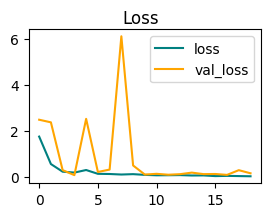

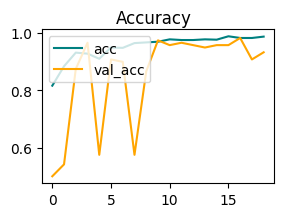

Fold Training Time: 0 hour(s) and 0 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-B: 96.61016845703125
F1Score-R: 96.72130584716797
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/8c9fa241-892b-4cbf-bef9-59ce9fa01f4c
Epoch 1/25
101/105 [===========================>..] - ETA: 0s - loss: 2.3964 - accuracy: 0.7946
Epoch 1: val_loss improved from inf to 1.55326, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-1
105/105 [==============================] - 6s 33ms/step - loss: 2.3573 - accuracy: 0.7976 - val_loss: 1.5533 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
104/105 [============================>.] - ETA: 0s - loss: 0.5693 - accuracy: 0.8894
Epoch 2: val_loss improved from 1.55326 to 0.57295, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-1
105/105 [==============================] - 4s 34ms/step -

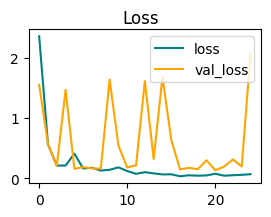

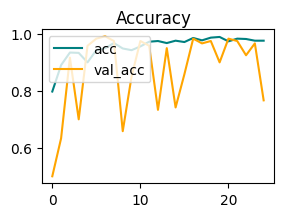

Fold Training Time: 0 hour(s) and 0 mins
Precision: 98.33333492279053  -  Recall: 98.33333492279053
Accuracy: 98.33333492279053
F1Score-B: 98.30508422851562
F1Score-R: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/8e2cc4ed-1aa0-4a97-b97d-787b463287b1
Epoch 1/25
102/105 [============================>.] - ETA: 0s - loss: 1.2453 - accuracy: 0.8174
Epoch 1: val_loss improved from inf to 1.34672, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-2
105/105 [==============================] - 7s 37ms/step - loss: 1.2292 - accuracy: 0.8167 - val_loss: 1.3467 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
101/105 [===========================>..] - ETA: 0s - loss: 0.7264 - accuracy: 0.8750
Epoch 2: val_loss did not improve from 1.34672
105/105 [==============================] - 1s 11ms/step - loss: 0.7503 - accuracy: 0.8726 - val_loss: 4.6843 - val_accur

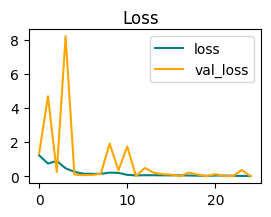

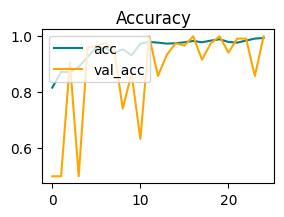

Fold Training Time: 0 hour(s) and 0 mins
Precision: 100.0  -  Recall: 100.0
Accuracy: 100.0
F1Score-B: 100.0
F1Score-R: 100.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/bdb7fefe-cdb1-4ee4-8ddb-9ff6d7874d8f
Epoch 1/25
101/105 [===========================>..] - ETA: 0s - loss: 1.1423 - accuracy: 0.8181
Epoch 1: val_loss improved from inf to 0.54425, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-3
105/105 [==============================] - 7s 38ms/step - loss: 1.1101 - accuracy: 0.8214 - val_loss: 0.5442 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/25
101/105 [===========================>..] - ETA: 0s - loss: 0.4250 - accuracy: 0.8973
Epoch 2: val_loss did not improve from 0.54425
105/105 [==============================] - 1s 11ms/step - loss: 0.4178 - accuracy: 0.8988 - val_loss: 3.3709 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/25
101/105 [===============

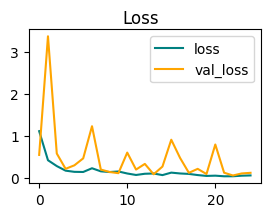

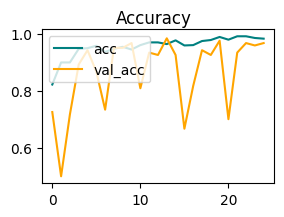

Fold Training Time: 0 hour(s) and 0 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-B: 96.66666412353516
F1Score-R: 96.66666412353516
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/bee5d348-79cb-4763-b536-6aa937c25692
Epoch 1/25
101/105 [===========================>..] - ETA: 0s - loss: 1.2988 - accuracy: 0.8131
Epoch 1: val_loss improved from inf to 1.94155, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-4
105/105 [==============================] - 6s 34ms/step - loss: 1.2643 - accuracy: 0.8131 - val_loss: 1.9415 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
101/105 [===========================>..] - ETA: 0s - loss: 0.3146 - accuracy: 0.9109
Epoch 2: val_loss did not improve from 1.94155
105/105 [==============================] - 1s 11ms/step - loss: 0.3124 - accuracy: 0.9119 - val_loss: 2.0324 - val_accur

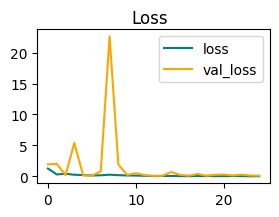

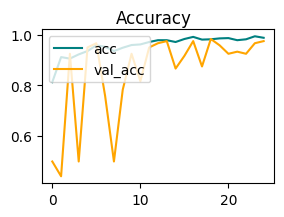

Fold Training Time: 0 hour(s) and 0 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-B: 96.7741928100586
F1Score-R: 96.55171966552734
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/92a26325-94e5-42f0-9344-04712106df95
Epoch 1/25
100/105 [===========================>..] - ETA: 0s - loss: 2.5512 - accuracy: 0.8138
Epoch 1: val_loss improved from inf to 1.08481, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-5
105/105 [==============================] - 6s 33ms/step - loss: 2.4755 - accuracy: 0.8155 - val_loss: 1.0848 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 2/25
102/105 [============================>.] - ETA: 0s - loss: 0.7317 - accuracy: 0.8664
Epoch 2: val_loss did not improve from 1.08481
105/105 [==============================] - 1s 11ms/step - loss: 0.7566 - accuracy: 0.8643 - val_loss: 1.2665 - val_accura

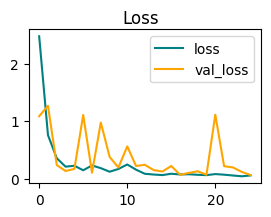

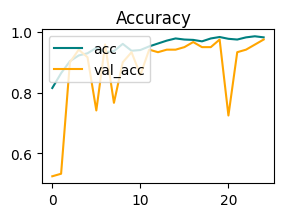

Fold Training Time: 0 hour(s) and 0 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.52066040039062
F1Score-R: 97.47898864746094
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/59fa116e-4f68-48e7-b001-cb4a5b10dd3a
Epoch 1/25
104/105 [============================>.] - ETA: 0s - loss: 2.3386 - accuracy: 0.8269
Epoch 1: val_loss improved from inf to 0.85814, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-6
105/105 [==============================] - 7s 37ms/step - loss: 2.3188 - accuracy: 0.8274 - val_loss: 0.8581 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 2/25
104/105 [============================>.] - ETA: 0s - loss: 1.2459 - accuracy: 0.8606
Epoch 2: val_loss did not improve from 0.85814
105/105 [==============================] - 1s 11ms/step - loss: 1.2341 - accuracy: 0.8619 - val_loss: 2.8923 - val_accur

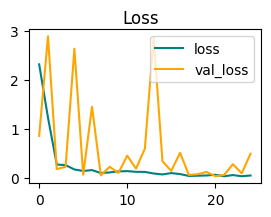

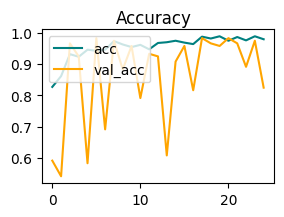

Fold Training Time: 0 hour(s) and 0 mins
Precision: 98.33333492279053  -  Recall: 98.33333492279053
Accuracy: 98.33333492279053
F1Score-B: 98.30508422851562
F1Score-R: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/abe70a58-4c25-4af6-be90-771d9612211f
Epoch 1/25
103/105 [============================>.] - ETA: 0s - loss: 2.4886 - accuracy: 0.7864
Epoch 1: val_loss improved from inf to 4.76680, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-7
105/105 [==============================] - 6s 32ms/step - loss: 2.4612 - accuracy: 0.7857 - val_loss: 4.7668 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
102/105 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.9032
Epoch 2: val_loss improved from 4.76680 to 1.47115, saving model to /content/MODEL/Model 2CLS-OB-4.0.1/FOLD-7
105/105 [==============================] - 4s 35ms/step -

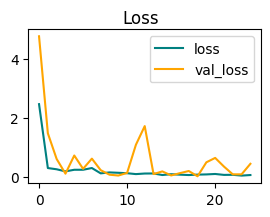

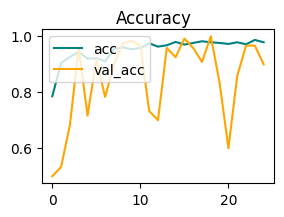

Fold Training Time: 0 hour(s) and 0 mins
Precision: 100.0  -  Recall: 100.0
Accuracy: 100.0
F1Score-B: 100.0
F1Score-R: 100.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 6 mins


In [ ]:
params = {
    "lr": 0.001,
    "epochs": 25,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_bld = []
f1_road = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_bld.append(f1_s[0])
        f1_road.append(f1_s[1])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-B"] = f1_bld[counter]
        run["eval/F1-R"] = f1_road[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-B: {f1_bld[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [ ]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-B: {avg_rate(f1_bld)}
Avg F1-Score-R: {avg_rate(f1_road)}
""")


Avg Accuracy: 98.02083298563957
Avg Precision: 98.02083298563957
Avg Recall: 98.02083298563957
Avg F1-Score-B: 98.02273178100586
Avg F1-Score-R: 98.0174970626831



In [ ]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-B"] = avg_rate(f1_bld)
run["eval/F1-R"] = avg_rate(f1_road)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/4e2e97b0-d1c6-477d-9406-06c49457f2d5
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [ ]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [ ]:
!neptune sync -p 'New-Thesis/Kaggle-2Cls-Only-Building' --offline-only


Offline container 9bd74ba5-695a-4018-b63e-b49a0969156d registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-1
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-1
Deleted: /content/.neptune/async/run__9bd74ba5-695a-4018-b63e-b49a0969156d__26622__kmxwo133
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-1 completed.
Offline container 9bd74baf-fe6f-4a26-8b82-66ae916a7273 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-2
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-2
Deleted: /content/.neptune/async/run__9bd74baf-fe6f-4a26-8b82-66ae916a7273__26622__zz9ks77x
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-2 completed.
Offline container 9bd74bb7-642f-4144-8768-8057cb234536 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-3
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-3
Deleted: /content/.neptune/async/run__9bd74bb7-642f-4144-8768-8057cb234536__26622__weay8156
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Buil

In [ ]:
!neptune clear


In [ ]:
!rm -r "/content/MODEL/Model 2CLS-OB-4.0.1"